# Covid-19 Dashboard
---

Analysis of Covid-19 cases based on data reported on the European CDC website. This version supports the new format and weekly publication that came into effect from Dec 2020.

Quick link to the [Dashboard](#dashboard)

**Modification history:**
- Updated to support new weekly version

---

Chandranath Gunjal (github.com/cdragun)

### Code <a id='code_section'></a>

In [1]:
import datetime
import os.path
import requests
import numpy as np
import pandas as pd

import IPython.display as ipd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', context='notebook', palette='muted')

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 10)


In [2]:
# Fetch file and data cleaning
def fetch_ECDC_data(url):
    """Fetch data from ECDC website - assumes that the data returned is in json format"""
    # fetch data
    response = requests.get(url, allow_redirects=True)
    if not response.ok:
        response.raise_for_status()

    # load into data frame
    return pd.read_json(response.content, typ='frame')


def load_data(asof, url):
    """Read local filename if it exists - otherwise fetch from ECDC website"""
    # file name spec for the cached (cleaned) data
    def local_filename(x): return 'ecdc_' + x.replace('-', '_') + '.csv'
    
    try:
        # read local file if it exists
        print('trying local')
        df = pd.read_csv(local_filename(asof), index_col=False) # na_filter=False
        data_asof = asof

    except Exception as exc:
        print(f'exception raised ({exc}). trying remote')
        df = cleanse_ECDC_data(fetch_ECDC_data(url))
        data_asof = df['week'].max()
        
        fname = local_filename(data_asof)
        if not os.path.exists(fname):
            print(f'caching data to {fname}')
            df.to_csv(local_filename(data_asof), index=False)
        else:
            print(f'cache [{fname}] already exists. not overwritten')

    return df, data_asof
        
    
def cleanse_ECDC_data(df):
    """Cleanse and reformat ECDC data"""
    # work on a copy
    ndf = df.copy()
    
    # rename columns
    rv = {'country_code': 'cid', 'year_week': 'week'}
    c = [rv[k] if k in rv else k for k in (i.lower() for i in ndf.columns)]
    ndf.columns = c
    
    # drop continents data
    ndf = ndf.dropna(axis=0)
    
    # collect static information - to re-insert after pivoting the indicator
    countries = dict(zip(ndf['cid'], ndf['country']))
    populations = dict(zip(ndf['cid'], ndf['population']))
    continents = dict(zip(ndf['cid'], ndf['continent']))

    ndf = ndf.pivot(['cid', 'week'], columns=['indicator'], values='weekly_count')
    ndf = ndf.reset_index()
    
    ndf['country'] = [countries[c] for c in ndf['cid']]
    ndf['population'] = [populations[c] for c in ndf['cid']]
    ndf['continent'] = [continents[c] for c in ndf['cid']]
    ndf.columns.name = None

    # sort by country and week
    ndf.sort_values(by=['cid', 'week'], ascending=[True, True],
                    axis=0, inplace=True, ignore_index=True)
    
    # append global totals
    ndf = ndf.append(compute_global_totals(ndf, 'W_'), ignore_index=True)

    # append cumulative counts
    ndf['cum_cases'] = ndf.groupby(['cid'])['cases'].cumsum()
    ndf['cum_deaths'] = ndf.groupby(['cid'])['deaths'].cumsum()
    return ndf


def compute_global_totals(df, prefix):
    """Return dataframe with by-continent and world-wide statistics"""
    if df['cid'].str.startswith(prefix).any():
        raise ValueError('duplicate error: world stats already exist in dataframe')
        
    # consolidate by continent. cid = prefix + first two letters of continent name
    cc = df.groupby(['continent', 'week'], as_index=False).sum()
    cc['country'] = cc['continent']
    cc['cid'] = prefix + cc['continent'].str[:2].str.upper()
   
    # worldwide numbers
    ww = df.groupby(['week'], as_index=False).sum()
    ww['country'] = 'World'
    ww['continent'] = 'World'
    ww['cid'] = prefix + 'WW'
    return pd.concat([cc, ww])


def fix_missing_numeric(df, col, fillval=0):
    """Fill blanks and NAs with zeroes"""
    m = df[col].eq('')
    df.loc[m, col] = fillval
    df[col] = df[col].fillna(fillval)
    return


def lookup_country(df, substr):
    """Lookup a country name or cid. Empty string prints full list"""
    substr, n = substr.upper(), len(substr)
    
    # simple search - either matches cid or beginning of country name
    all_names = dict(sorted(zip(df['cid'], df['country'])))
    subset = {id:name for id, name in all_names.items() \
              if substr == id or substr == name.upper()[:n]}
    
    # display
    for i, (id, name) in enumerate(subset.items(), 1):
        print('{: <26}'.format((id + ': ' + name)[:24]), end='')
        if i % 3 == 0: print()
    print()
    return


def week_of_year(dt=None):
    """Returns a string in yyyy-ww format for date given (or today)"""
    if dt is None: dt = datetime.date.today()
    
    y, w, _ = datetime.date.isocalendar(dt)
    return '{:d}-{:02d}'.format(y, w)


def diff_in_weeks(d1, d2):
    """Difference in weeks for d1 and d2 (in yyyy-ww string format)"""
    if d1 > d2: d1, d2 = d2, d1
    
    y1, w1 = map(int, d1.split('-'))
    y2, w2 = map(int, d2.split('-'))
    
    return 52 * (y2 - y1) + (w2 - w1)


In [3]:
# Statistics / computations
def compute_timeline(df, threshold, col, new_col):
    """Count periods from when a variable crossed a given threshold. Creates a new column in df"""
    df[new_col] = 0
    df.loc[df[col] >= threshold, new_col] = 1
    df[new_col] = df.groupby(['cid'])[new_col].cumsum()
    return


def compute_fatality_ratio(df, lag, new_col, num_col='cum_deaths', denom_col='cum_cases'):
    """Compute fatality ratio with a given lag. Creates a new column in given df"""                    
    def shifted_fr(x):
        x[new_col] = (x[num_col] / x[denom_col].shift(lag)).fillna(0).replace(np.inf, 0)
        return x
        
    df[new_col] = df.groupby(['cid']).apply(shifted_fr)[new_col]
    return


def compute_growth_rate(df, lag, col, new_col, dbl_col):
    """Compute average growth rate of a variable. Creates new columns in df"""
    def growth_rate(x):
        x[new_col] = (x[col] / x[col].shift(lag)).pow(1.0/lag).sub(1).\
                        fillna(0).replace(np.inf, 0)
        return x
    
    df[new_col] = df.groupby(['cid']).apply(growth_rate)[new_col]
    df[dbl_col] = (np.log(2) / np.log(df[new_col].add(1))).\
                        fillna(0).replace(np.inf, 0)
    return


def compute_percapita_stat(df, col, new_col, base=1e6):
    """Rebase statistic to per unit of population"""
    df[new_col] = df[col].div(df['population']).mul(base).\
                        fillna(0).replace(np.inf, 0)
    return


def compute_ma(df, window, col, new_col):
    """Compute moving average of a given column"""
    df[new_col] = df.groupby(['cid'])[col].apply(lambda s: s.rolling(window).mean()).\
                        fillna(0)
    return


def compute_stats(df, threshold, avg_period, lag):
    """Run all computations"""
    # Create a timeline - first day when cum_cases exceeded a threshold
    compute_timeline(df, threshold, 'cum_cases', 'timeline')

    # compute fatality ratios - both cumulative and spot
    df['daily_cases'] = df['cases'].div(7.0).round(0)
    df['daily_deaths'] = df['deaths'].div(7.0).round(0)
    compute_fatality_ratio(df, 0, 'fatality', 'cum_deaths', 'cum_cases')
    compute_fatality_ratio(df, lag, 'fr_spot', 'deaths', 'cases')

    # compute n-day growth rates and doubling times
    compute_growth_rate(df, avg_period, 'cum_cases', 'gr_cases', 'dbl_cases')
    compute_growth_rate(df, avg_period, 'cum_deaths', 'gr_deaths', 'dbl_deaths')
    
    # compute cum cases/deaths per million of population
    compute_percapita_stat(df, 'cum_cases', 'pm_cases', 1e6)
    compute_percapita_stat(df, 'cum_deaths', 'pm_deaths', 1e6)
    
    # moving average of daily cases / deaths
    # compute_ma(df, avg_period, 'cases', 'ma_cases')
    # compute_ma(df, avg_period, 'deaths', 'ma_deaths')
 
    # sort out column order
    df = pd.DataFrame(df, columns=['week', 'country', 'cid', 'timeline',
                                   'continent', 'population',
                                   'cases', 'deaths', 'daily_cases', 'daily_deaths',
                                   'cum_cases', 'cum_deaths', 'pm_cases', 'pm_deaths',
                                   'fatality','fr_spot',
                                   'gr_cases', 'dbl_cases', 'gr_deaths', 'dbl_deaths'])
    return df


In [4]:
# Reports

nice_names = {'week': 'Week', 'country': 'Country', 'cid': 'CID',
              'cases': 'Weekly Cases', 'deaths': 'Weekly Deaths',
              'population': 'Population',
              'cum_cases': 'Cum. Cases', 'cum_deaths': 'Cum. Deaths', 
              'timeline': 'Timeline',
              'fatality': 'Fatality',   'fr_spot': 'Fatality (spot)',
              'gr_cases': 'Growth-r Cases', 'gr_deaths': 'Growth-r Deaths',
              'pm_cases': 'Cases (pm)',  'pm_deaths': 'Deaths (pm)',
              'daily_cases': 'Daily Cases',    'daily_deaths': 'Daily Deaths',
              'dbl_cases': 'Double-t Cases', 'dbl_deaths': 'Double-t Deaths'
             }

fmt_style = {'week': '{:s}',          'cases': '{:,.0f}',
             'deaths': '{:,.0f}',     'population': '{:,.0f}',
             'cum_cases': '{:,.0f}',  'cum_deaths': '{:,.0f}', 
             'fatality': '{:.2%}',    'fr_spot': '{:.2%}',
             'gr_cases': '{:.2%}',    'gr_deaths': '{:.2%}',
             'pm_cases': '{:,.0f}',   'pm_deaths': '{:,.0f}',
             'daily_cases': '{:,.0f}',  'daily_deaths': '{:,.0f}',
             'dbl_cases': '{:,.0f}',    'dbl_deaths': '{:,.0f}',
             }


def make_nice_names(names):
    """Return nice names for given list"""
    return [nice_names[c] if c in nice_names else c.capitalize() for c in names]


def spruce(df, show_cols=[], hide_cols=[], show_nice_names=False):
    """Spruce up index & columns for displaying a dataframe"""
    # choose columns to show
    all_cols = show_cols if len(show_cols) > 0 else list(df.columns)
    for c in hide_cols:
        if c in all_cols:
            all_cols.remove(c)
    
    y = pd.DataFrame(df, columns=all_cols)
 
    # pretty up index and columns names
    y.index = np.arange(1, len(df) + 1)
    if show_nice_names: y.columns = make_nice_names(all_cols)
    return y


def stylise(df, show_nice_names=False):
    """Apply styles to dataframe"""
    return df.style.format({nice_names[c]:f for c,f in fmt_style.items()}
                                if show_nice_names else fmt_style)
    
    
def rpt_show(df, caption, asof=None, sortby=None, count=0,
             hide_cols=['population'], show_nice_names=False):
    """Show part of a dataframe"""
    if count == 0: count = len(df)

    y = df
    if asof is not None: y = y[y.week == asof]
    if sortby is not None: y = y.sort_values([sortby], ascending=False)
    
    # show report 
    print('\n', caption, '\n')
    y = spruce(y.head(count), hide_cols=hide_cols, show_nice_names=show_nice_names)
    ipd.display(stylise(y, show_nice_names=show_nice_names))
    return


def rpt_stats(df, asof, variables, filter_col='cum_deaths', threshold=100,
              sort_ascending=False, count=10, show_nice_names=False):
    """Stats report"""
    main_cols = ['country', 'cid']
    
    sections = []
    for i, v in enumerate(variables, 1):
        x = df[(df[filter_col] > threshold) & (df['week'] == asof) &
                      (~ df['cid'].str.startswith('W_'))]\
                   .sort_values([v], ascending=sort_ascending)\
                   .head(count)
        
        x = spruce(x, main_cols + [v])
        x.columns = [c + str(i) for c in main_cols] + [v]
        sections.append(x)
    y = pd.concat(sections, axis=1)
    if show_nice_names: y.columns = make_nice_names(y.columns)

    print('\n', 'Statistics for ' + asof, '\n')
    ipd.display(stylise(y, show_nice_names=show_nice_names))
    return


def rpt_history(df_all, cid, *, history=7, show_nice_names=False):
    """Show n-period history for given cid"""
    
    # show history
    df = df_all[(df_all.cid == cid) & (df_all.timeline > 0)]
    if len(df) < 2:
        print("Insufficient data for requested country")
        return
    
    caption = '{} ({}), pop. {:,}: Last {} weeks. Timeline: Week-{}'.\
               format(df['country'].iloc[0], cid, df['population'].max(),
                      history, df['timeline'].max())
    rpt_show(df.tail(history)[::-1], caption,
             hide_cols=['country', 'cid', 'population', 'continent'],
             show_nice_names=show_nice_names)
    return


def rpt_country(df_all, cid, *, history=7, show_nice_names=False):
    """Summary report for given country"""
    
    # show history
    rpt_history(df_all, cid, history=history, show_nice_names=show_nice_names)

    # show charts
    df = df_all[(df_all.cid == cid) & (df_all.timeline > 0)]
    if len(df) < 2:
        print("Insufficient data for requested country")
        return None
  
    plt.figure(1, figsize=(18, 21))
    ax = plt.subplot(321)
    df.plot(ax=ax, x='timeline', y=['cum_cases'], marker='.')

    ax = plt.subplot(322)
    df.plot(ax=ax, x='timeline', y=['cum_deaths'], marker='.')

    ax = plt.subplot(323)
    df.plot(ax=ax, x='timeline', y='daily_cases', kind='line', marker='.')
    df.plot(ax=ax, x='timeline', y='gr_cases', secondary_y='gr_cases', kind='line', marker='.')
    ax.right_ax.set_ylim(0, 0.5)
                             
    ax = plt.subplot(324)
    df.plot(ax=ax, x='timeline', y='daily_deaths', kind='line', marker='.')
    df.plot(ax=ax, x='timeline', y='gr_deaths', secondary_y='gr_deaths', kind='line', marker='.')
    ax.right_ax.set_ylim(0, 0.5)

    ax = plt.subplot(325)
    df.plot(ax=ax, x='timeline', y=['fatality', 'fr_spot'], marker='.')
    ax.set_ylim(0, 0.2)

    ax = plt.subplot(326)
    df.plot(ax=ax, x='timeline', y=['dbl_cases', 'dbl_deaths'], marker='.')

    plt.show()
    return


In [5]:
# charts
def chart(df, title, *, cid, x, y, log_scale=None, filter_timeline=False,
          figsize=(16,8), **kwargs):
    """Generic charting routine
    
    cid:             a single cid or a list
    x:               x-axis column
    y:               y-axis column(s)
    log_scale:       scale axis on a log scale; valid values are None, x, y or both
    filter_timeline: additionally filter data for timeline > 0
    
    Note that both cid and y cannot be lists.
    """
    # check parameters
    if np.isscalar(cid):
        cid = [cid]
    if np.isscalar(y):
        y = [y]
    assert len(cid) == 1 or len(y) == 1, 'Both cid and y cannot be arraylike'
    
    # log graph?
    p_logx = log_scale == 'x'
    p_logy = log_scale == 'y'
    p_loglog = log_scale == 'both'

    # filter data
    mask = df['cid'].isin(cid)
    if x == 'timeline' or filter_timeline:
        mask &= df['timeline'] > 0

    needed_cols = [x] + y
    cnames = dict(zip(df['cid'], df['country']))   # TODO: Refactor

    # create the chart
    plt.figure(1, figsize=figsize)
    ax = plt.subplot(111)
    for c in cid:
        lbl = y if len(cid) == 1 else [cnames.get(c, c)]
        data = pd.DataFrame(df[mask & (df['cid'] == c)], columns=needed_cols)
        data.plot(ax=ax, x=x, y=y, label=lbl, logx=p_logx, logy=p_logy, loglog=p_loglog, **kwargs)

    plt.title(title)
    plt.show()
    return


def timeline_chart(df, title, *, cid, y, log_scale=None, **kwargs):
    """Chart variable for given countries"""
    chart(df, title, cid=cid, x='timeline', y=y, log_scale=log_scale, **kwargs)
    return


### Dashboard <a id='dashboard'></a>

- This will fetch the data from the ECDC website and save a clean (dated) version in the local directory
- Subsequent loads will read the local version if it exists.


Click here to go to the [Code section](#code_section)

In [6]:
# general parameters
# ------------------
# ECDC website - caveat, the file's name format changes every so often
url1 = 'https://opendata.ecdc.europa.eu/covid19/nationalcasedeath/json'

# Week0 for each country is determined when cum_cases >= threshold
timeline_threshold = 100

# Period over which to compute the average growth rate
avg_period = 2

# Lag to use for fatality ratio
lag = 2

# subsets of interest
home = 'GBR'
world = 'W_WW'
monitor = ['W_WW', 'USA', 'BRA', 'GBR', 'ITA', 'ESP', 'DEU', 'FRA', 'CHE', 'SWE',
           'CHN', 'JPN', 'KOR', 'RUS', 'IND']
continents = ['W_WW', 'W_AS', 'W_EU', 'W_AM', 'W_AF', 'W_OC']


#### Weekly update

Change asof to the current week and re-run all cells

In [7]:
# Load data and update asof to latest week. Can't automate the local caching efficiently
# as there is no timestamp info on the website - have to download the full time series
# to work it out. The data is updated at some time every Thursday
request_week = '2021-32'
curr_week = week_of_year()

df, asof = load_data(curr_week if diff_in_weeks(request_week, curr_week) > 2 else request_week, url1)
print('loaded data asof {} vs requested {} for the current week {}'.format(asof, request_week, curr_week))
df = compute_stats(df, timeline_threshold, avg_period, lag)

# data subsets 
df_world = df[df['cid'] == world]
df_home  = df[df['cid'] == home]
df_mon   = df[df['cid'].isin(monitor)]
df_continents = df[df['cid'].isin(continents)]


trying local
loaded data asof 2021-32 vs requested 2021-32 for the current week 2021-34


### Description of column names
---
- *cid:* Geographic ID. WW has been included for World statistics
- *timeline:* Day-1 is the first day that cum_cases for a country exceeds a certain threshold (defined by timeline_threshold; see above)


- *cases:* Cases reported for the given week
- *daily_cases:* Cases/day for the week 
- *cum_cases:* Cumulative cases up to the given week
- *pm_cases:* Total cases per million of population


- *deaths:* Deaths reported for the given week
- *daily_deaths:* Deaths/day for the week
- *cum_deaths:* Cumulative deaths up to the given week
- *pm_deaths:* Total deaths per million of population


- *fatality:* Fatality rate (%age) based on cumulative statistics i.e. cum_deaths(t) / cum_cases(t)
- *fr_spot:* Spot fatality rate based on recent statistics i.e. deaths(t) / cases(t - lag)


- *gr_cases:* The growth rate (%age) in cases reported. This is a 3-day compounded moving average to smoothen the data
- *gr_deaths:* The growth rate (%age) in deaths reported. Computed similar to gr_cases
- *dbl_cases:* Days for cumulative cases reported to double in number. Implied from the growth rate; therefore lagging because of the averaging period used
- *dbl_deaths:* Days for cumulative deaths reported to double in number


---

### Monitor

Statistics for countries in the monitor list 

In [8]:
rpt_show(df_continents, 'Statistics by continent for: ' + asof, asof, 'cum_deaths',
         hide_cols=['population', 'week', 'cid', 'continent'], show_nice_names=True)


 Statistics by continent for: 2021-32 



,Country,Timeline,Weekly Cases,Weekly Deaths,Daily Cases,Daily Deaths,Cum. Cases,Cum. Deaths,Cases (pm),Deaths (pm),Fatality,Fatality (spot),Growth-r Cases,Double-t Cases,Growth-r Deaths,Double-t Deaths
1,World,83,"4,452,173","67,204","636,025","9,601","207,849,243","4,366,247","26,809",563,2.10%,1.64%,2.21%,32,1.57%,45
2,America,77,"1,506,128","19,776","215,161","2,825","80,476,635","2,059,051","78,767","2,015",2.56%,1.61%,1.86%,38,0.98%,71
3,Europe,78,"1,087,120","9,892","155,303","1,413","61,095,579","1,221,930","71,776","1,436",2.00%,0.97%,1.77%,39,0.75%,93
4,Asia,83,"1,595,514","31,225","227,931","4,461","58,844,653","899,568","13,081",200,1.53%,1.98%,2.93%,24,3.69%,19
5,Africa,75,"248,654","6,140","35,522",877,"7,292,058","183,766","5,444",137,2.52%,2.27%,3.90%,18,3.59%,20
6,Oceania,75,"14,757",171,"2,108",24,"140,318","1,932","3,330",46,1.38%,1.41%,10.53%,7,7.02%,10


In [9]:
rpt_show(df_mon, 'Statistics by country for: ' + asof, asof, 'cum_deaths',
         hide_cols=['population', 'week', 'cid', 'continent'], show_nice_names=False)


 Statistics by country for: 2021-32 



,country,timeline,cases,deaths,daily_cases,daily_deaths,cum_cases,cum_deaths,pm_cases,pm_deaths,fatality,fr_spot,gr_cases,dbl_cases,gr_deaths,dbl_deaths
1,World,83,"4,452,173","67,204","636,025","9,601","207,849,243","4,366,247","26,809",563,2.10%,1.64%,2.21%,32,1.57%,45
2,United States Of America,76,"916,459","4,807","130,923",687,"36,681,559","621,636","110,820","1,878",1.69%,0.86%,2.37%,30,0.68%,102
3,Brazil,75,"198,427","5,907","28,347",844,"20,364,099","569,058","95,804","2,677",2.79%,2.37%,1.06%,66,1.09%,64
4,India,74,"255,559","3,333","36,508",476,"32,225,513","431,642","23,352",313,1.34%,1.17%,0.83%,84,0.81%,86
5,Russia,74,"153,086","5,618","21,869",803,"6,600,836","170,499","45,232","1,168",2.58%,3.46%,2.26%,31,3.18%,22
6,United Kingdom,76,"173,194",597,"24,742",85,"6,267,437","130,953","92,087","1,924",2.09%,0.33%,3.24%,22,0.47%,146
7,Italy,78,"44,252",212,"6,322",30,"4,440,669","128,432","74,456","2,153",2.89%,0.56%,0.97%,71,0.14%,488
8,France,77,"165,877",452,"23,697",65,"6,471,035","112,702","96,123","1,674",1.74%,0.30%,2.61%,27,0.35%,198
9,Germany,77,"31,190",87,"4,456",12,"3,823,139","91,871","45,970","1,105",2.40%,0.57%,0.67%,103,0.12%,603
10,Spain,77,"91,496",470,"13,071",67,"4,719,266","82,595","99,704","1,745",1.75%,0.29%,2.37%,30,0.58%,120


### Country Report

Show recent history and charts for a given country (or the world 'WW')

In [10]:
# find country - empty string prints full list
# lookup_country(df, 'so')


 United Kingdom (GBR), pop. 68,059,863: Last 8 weeks. Timeline: Week-76 



,week,timeline,cases,deaths,daily_cases,daily_deaths,cum_cases,cum_deaths,pm_cases,pm_deaths,fatality,fr_spot,gr_cases,dbl_cases,gr_deaths,dbl_deaths
1,2021-32,76,"173,194",597,"24,742",85,"6,267,437","130,953","92,087","1,924",2.09%,0.33%,3.24%,22,0.47%,146
2,2021-31,75,"213,576",637,"30,511",91,"6,094,243","130,356","89,542","1,915",2.14%,0.24%,3.42%,21,0.46%,150
3,2021-30,74,"182,755",561,"26,108",80,"5,880,667","129,719","86,404","1,906",2.21%,0.18%,4.03%,18,0.39%,177
4,2021-29,73,"263,973",450,"37,710",64,"5,697,912","129,158","83,719","1,898",2.27%,0.24%,5.48%,13,0.28%,244
5,2021-28,72,"312,694",283,"44,671",40,"5,433,939","128,708","79,841","1,891",2.37%,0.14%,4.98%,14,0.19%,373
6,2021-27,71,"190,712",194,"27,245",28,"5,121,245","128,425","75,246","1,887",2.51%,0.19%,4.03%,18,0.13%,547
7,2021-26,70,"198,099",131,"28,300",19,"4,930,533","128,231","72,444","1,884",2.60%,0.23%,3.19%,22,0.10%,696
8,2021-25,69,"102,394",124,"14,628",18,"4,732,434","128,100","69,533","1,882",2.71%,0.22%,1.72%,41,0.08%,905


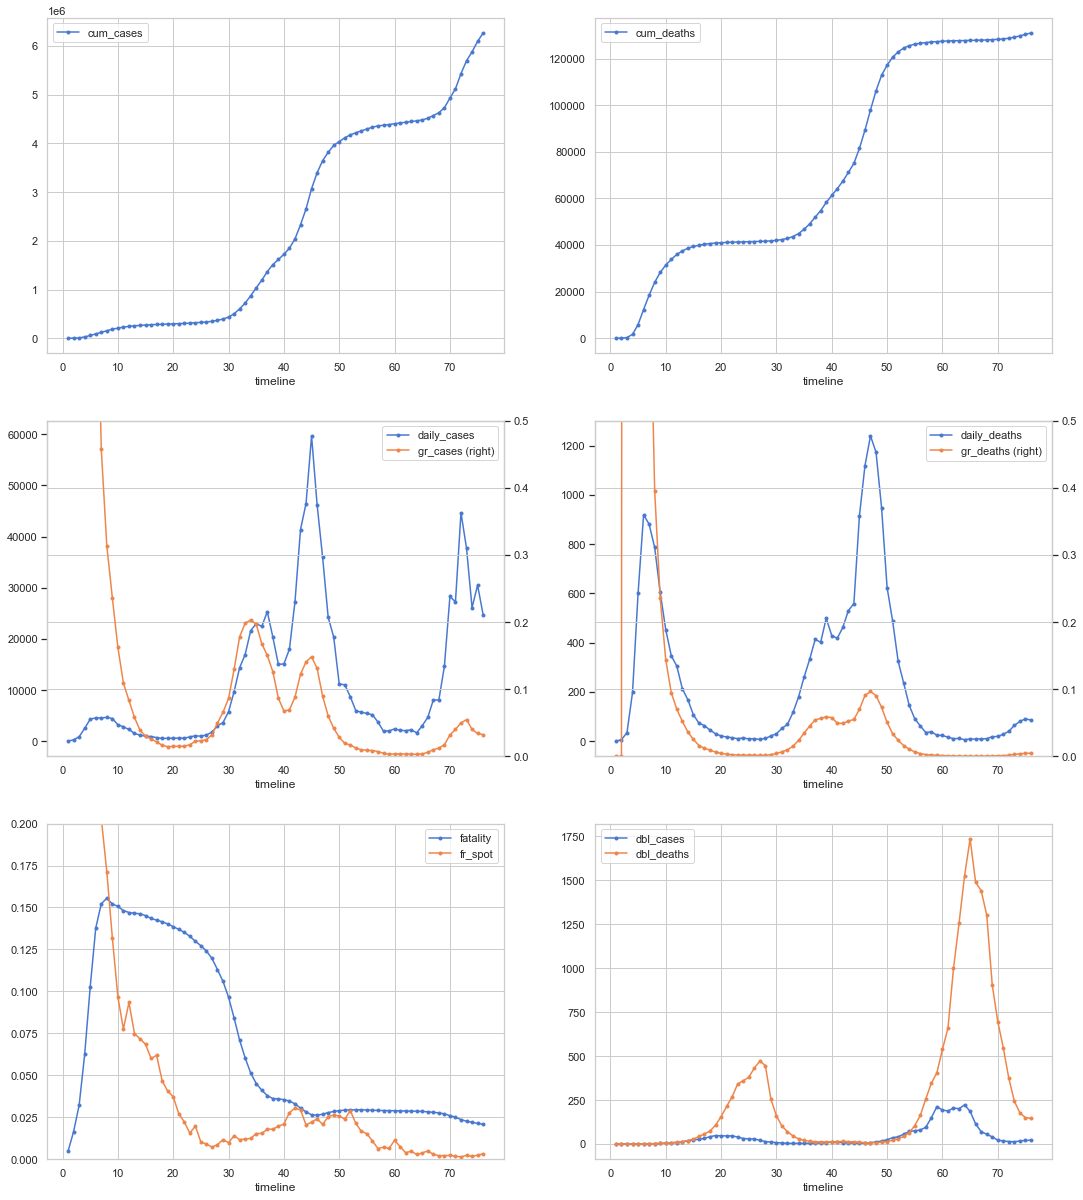

In [11]:
rpt_country(df, 'GBR', history=8)

### Daily Rankings

Daily rankings by variable. By default, countries included iff cum_deaths > 100.

In [12]:
rpt_stats(df, asof, ['cases', 'deaths', 'cum_cases', 'cum_deaths'], show_nice_names=True)


 Statistics for 2021-32 



,Country1,Cid1,Weekly Cases,Country2,Cid2,Weekly Deaths,Country3,Cid3,Cum. Cases,Country4,Cid4,Cum. Deaths
1,United States Of America,USA,"916,459",Indonesia,IDN,"10,492",United States Of America,USA,"36,681,559",United States Of America,USA,"621,636"
2,India,IND,"255,559",Brazil,BRA,"5,907",India,IND,"32,225,513",Brazil,BRA,"569,058"
3,Iran,IRN,"230,356",Russia,RUS,"5,618",Brazil,BRA,"20,364,099",India,IND,"431,642"
4,Brazil,BRA,"198,427",United States Of America,USA,"4,807",Russia,RUS,"6,600,836",Mexico,MEX,"248,652"
5,Indonesia,IDN,"188,323",Mexico,MEX,"3,962",France,FRA,"6,471,035",Peru,PER,"197,487"
6,Turkey,TUR,"187,922",India,IND,"3,333",United Kingdom,GBR,"6,267,437",Russia,RUS,"170,499"
7,United Kingdom,GBR,"173,194",Iran,IRN,"3,193",Turkey,TUR,"6,059,788",United Kingdom,GBR,"130,953"
8,France,FRA,"165,877",Vietnam,VNM,"2,377",Argentina,ARG,"5,088,259",Italy,ITA,"128,432"
9,Russia,RUS,"153,086",South Africa,ZAF,"2,328",Colombia,COL,"4,870,877",Colombia,COL,"123,580"
10,Malaysia,MYS,"142,359",Kazakhstan,KAZ,"1,816",Spain,ESP,"4,719,266",Indonesia,IDN,"117,588"


In [13]:
rpt_stats(df, asof, ['pm_cases', 'pm_deaths', 'gr_cases', 'gr_deaths'], show_nice_names=True)


 Statistics for 2021-32 



,Country1,Cid1,Cases (pm),Country2,Cid2,Deaths (pm),Country3,Cid3,Growth-r Cases,Country4,Cid4,Growth-r Deaths
1,Andorra,AND,"196,240",Peru,PER,"5,990",Vietnam,VNM,32.15%,Vietnam,VNM,110.26%
2,Montenegro,MNE,"171,212",Hungary,HUN,"3,075",French Polynesia,PYF,22.13%,Fiji,FJI,27.86%
3,Bahrain,BHR,"159,216",Bosnia And Herzegovina,BIH,"2,960",Thailand,THA,19.69%,Liberia,LBR,22.20%
4,Czechia,CZE,"156,752",Czechia,CZE,"2,840",Eswatini,SWZ,17.19%,Thailand,THA,20.88%
5,Maldives,MDV,"146,396",Brazil,BRA,"2,677",Fiji,FJI,15.52%,Cuba,CUB,18.47%
6,Slovakia,SVK,"142,963",North Macedonia,MKD,"2,674",Cuba,CUB,14.25%,French Polynesia,PYF,17.43%
7,Aruba,ABW,"125,096",Montenegro,MNE,"2,647",Botswana,BWA,13.22%,Myanmar,MMR,16.75%
8,Slovenia,SVN,"124,907",Bulgaria,BGR,"2,639",Malaysia,MYS,11.48%,Malaysia,MYS,16.71%
9,Cyprus,CYP,"122,569",Colombia,COL,"2,429",Morocco,MAR,9.82%,Kazakhstan,KAZ,13.65%
10,Georgia,GEO,"120,721",Argentina,ARG,"2,414",Japan,JPN,9.80%,Mongolia,MNG,13.54%


In [14]:
rpt_stats(df, asof, ['fatality', 'fr_spot'], show_nice_names=True)


 Statistics for 2021-32 



,Country1,Cid1,Fatality,Country2,Cid2,Fatality (spot)
1,Yemen,YEM,19.24%,Yemen,YEM,29.31%
2,Peru,PER,9.25%,Somalia,SOM,18.14%
3,Mexico,MEX,8.00%,Syria,SYR,16.04%
4,Sudan,SDN,7.40%,Egypt,EGY,15.33%
5,Syria,SYR,7.35%,North Macedonia,MKD,12.30%
6,Ecuador,ECU,6.45%,Taiwan,TWN,6.11%
7,Egypt,EGY,5.82%,Bulgaria,BGR,6.09%
8,Somalia,SOM,5.40%,Jamaica,JAM,5.97%
9,Taiwan,TWN,5.18%,Bosnia And Herzegovina,BIH,5.61%
10,Bosnia And Herzegovina,BIH,4.68%,Angola,AGO,5.38%


### Timeline Charts

Cumulatives cases and deaths against the timeline for each country. Day 1 on the timeline is the first day when total cases exceeds 100

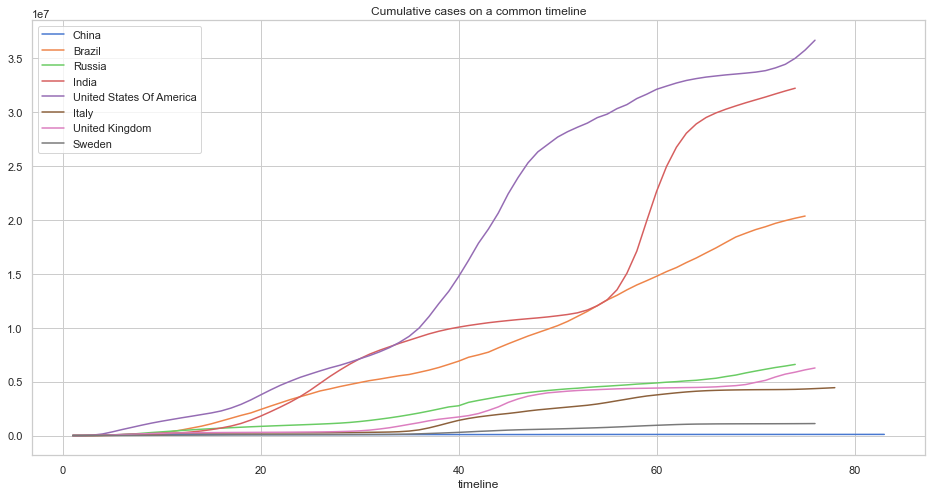

In [15]:
monitor2 = ['CHN', 'BRA', 'RUS', 'IND', 'USA', 'ITA', 'GBR', 'SWE']

timeline_chart(df, 'Cumulative cases on a common timeline',
               cid=monitor2, y='cum_cases', log_scale='')

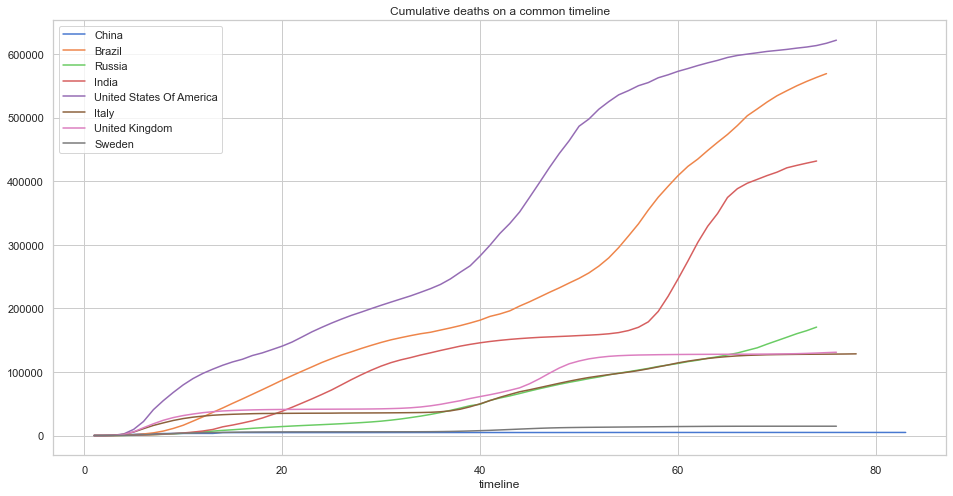

In [16]:
timeline_chart(df, 'Cumulative deaths on a common timeline',
               cid=monitor2, y='cum_deaths', log_scale='', marker='')

### Quick chart

Generic chart to quickly plot different variables


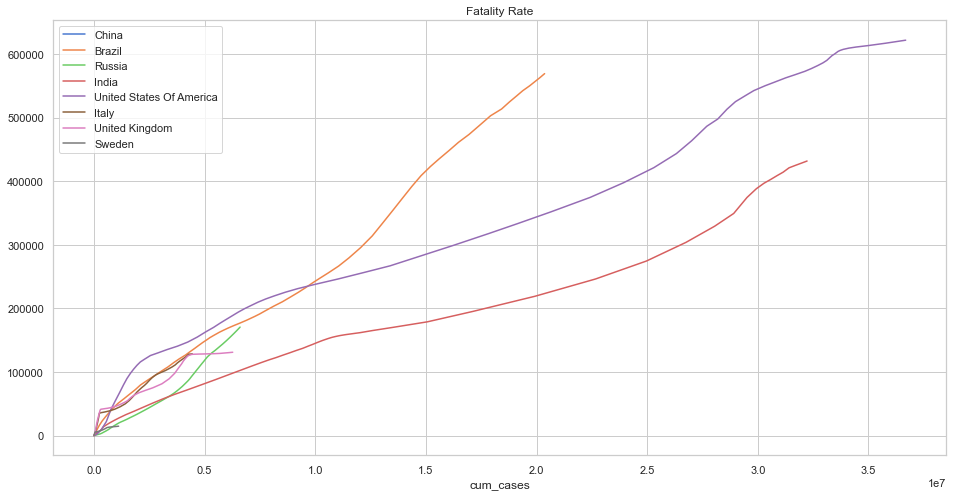

In [17]:
chart(df, 'Fatality Rate', cid=monitor2, x='cum_cases', y='cum_deaths',
      log_scale='', filter_timeline=True, marker='')

### Inflection point - Where does the plateau start?

Monitor the  daily cases / deaths against the China timeline. 

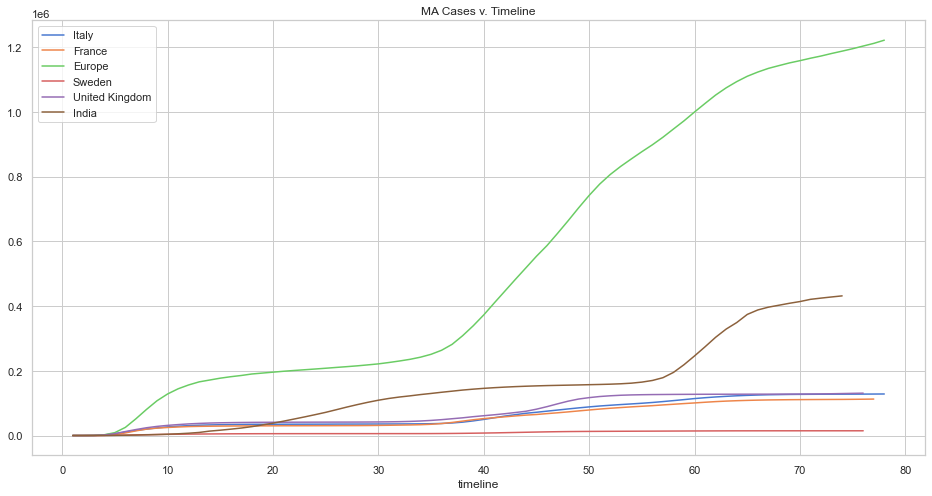

In [18]:
monitor3 = ['ITA', 'FRA', 'W_EU','SWE', 'GBR', 'IND']
chart(df, 'MA Cases v. Timeline', cid=monitor3, x='timeline', y='cum_deaths',
      log_scale='', filter_timeline=True, marker='')

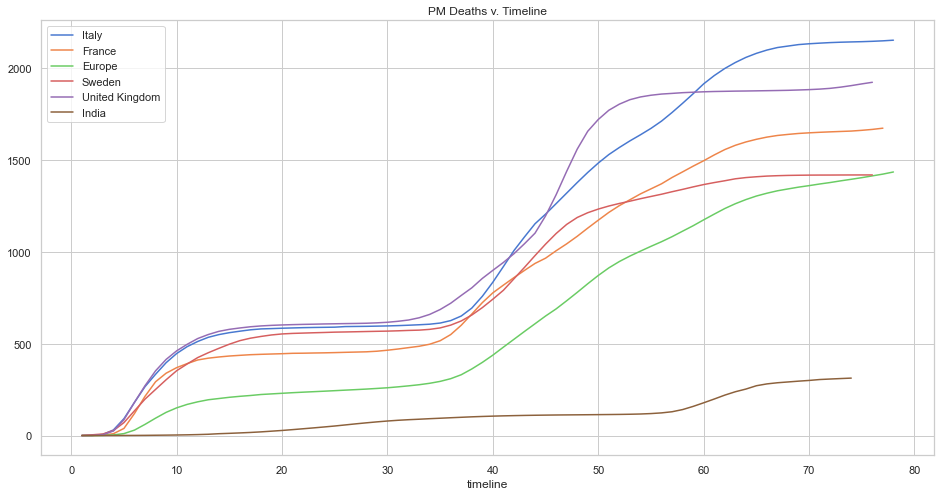

In [19]:
chart(df, 'PM Deaths v. Timeline', cid=monitor3 , x='timeline', y='pm_deaths',
      log_scale='', filter_timeline=True, marker='')